## Importing Relevant Libraries

#### General

In [1]:
import pandas as pd
import numpy as np

#### For clustering

In [2]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn import metrics
from scipy.spatial.distance import cdist

#### For principal component analysis

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#### For plotting

In [4]:
import matplotlib.pyplot as plt

# =============================================================

# 1. Reading in the data

# =============================================================

### Read in data from PVL-Delta model

In [5]:
df_pvl_delta = pd.read_csv("./data/parameter_igt_pvl_delta.csv")

#### Inspect the data

In [6]:
df_pvl_delta.head()

,group,SubID,LR,Outcome_Sens,Response_cons,Loss_Aver
0,young,1,0.159011,0.487522,0.686815,0.954498
1,young,2,0.064666,0.511008,1.391790,0.295529
2,young,3,0.113089,0.465141,0.918734,0.533232
3,young,4,0.089273,0.500391,0.703737,0.869859
4,young,5,0.233898,0.488053,0.897867,0.511095


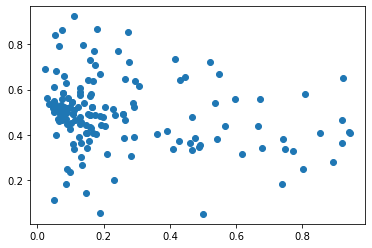

In [7]:
plt.scatter(df_pvl_delta["LR"], df_pvl_delta["Outcome_Sens"])

#### Processing

In [8]:
# Setting the SubID column as the index of the df
df_pvl_delta.drop(columns=['SubID'], inplace=True)

In [9]:
df_pvl_delta.head()

,group,LR,Outcome_Sens,Response_cons,Loss_Aver
0,young,0.159011,0.487522,0.686815,0.954498
1,young,0.064666,0.511008,1.391790,0.295529
2,young,0.113089,0.465141,0.918734,0.533232
3,young,0.089273,0.500391,0.703737,0.869859
4,young,0.233898,0.488053,0.897867,0.511095


### Read in data from the ORL model

In [10]:
df_orl = pd.read_csv("./data/parameter_igt_orl.csv")

#### Inspect the data

In [11]:
df_orl.head()

,subjID,A+,A-,K,BetaF,BetaP,A+-A-
0,old,0.324444,0.068862,1.502130,2.523191,-5.547480,0.255581
1,old,0.885744,0.120145,0.012591,3.193244,-9.159800,0.765598
2,old,0.318205,0.078128,1.927309,0.615708,9.272336,0.240077
3,old,0.728192,0.106737,0.388407,2.595746,-2.239555,0.621455
4,old,0.356229,0.091987,1.810674,0.508605,9.825699,0.264241


#### Processing
In order to ensure the datsets are symmetrical, a SubID column is created and used as the index, as above. Due to the absence of the SubID column in this dataset however, this index can not be used to identify subjects across the three dataframes.

In [12]:
df_orl.rename(columns={'subjID':'group'}, inplace=True)
df_orl.head()

,group,A+,A-,K,BetaF,BetaP,A+-A-
0,old,0.324444,0.068862,1.502130,2.523191,-5.547480,0.255581
1,old,0.885744,0.120145,0.012591,3.193244,-9.159800,0.765598
2,old,0.318205,0.078128,1.927309,0.615708,9.272336,0.240077
3,old,0.728192,0.106737,0.388407,2.595746,-2.239555,0.621455
4,old,0.356229,0.091987,1.810674,0.508605,9.825699,0.264241


### Read in data from the VPP 

In [13]:
df_vpp = pd.read_csv("./data/parameters_igt_vpp.csv")

#### Inspect the data

In [14]:
df_vpp.head()

,group,SubID,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
0,young,1,0.038441,0.630402,1.207295,1.050323,-0.535035,-1.913099,0.669323,0.660446
1,young,2,0.045673,0.630331,1.628191,0.205205,-0.133367,-1.423580,0.427207,0.719352
2,young,3,0.045468,0.602974,1.395572,0.383055,-0.344822,-1.719826,0.493249,0.688723
3,young,4,0.035789,0.635677,1.067831,0.823790,-0.229192,-1.484455,0.625835,0.675971
4,young,5,0.060655,0.636276,1.802964,0.329246,-0.616020,-2.561017,0.439912,0.655563


#### Processing

In [15]:
df_vpp.drop(columns=['SubID'], inplace=True)
df_vpp.head()

,group,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
0,young,0.038441,0.630402,1.207295,1.050323,-0.535035,-1.913099,0.669323,0.660446
1,young,0.045673,0.630331,1.628191,0.205205,-0.133367,-1.423580,0.427207,0.719352
2,young,0.045468,0.602974,1.395572,0.383055,-0.344822,-1.719826,0.493249,0.688723
3,young,0.035789,0.635677,1.067831,0.823790,-0.229192,-1.484455,0.625835,0.675971
4,young,0.060655,0.636276,1.802964,0.329246,-0.616020,-2.561017,0.439912,0.655563


# =============================================================

# 2. Standardising the Data

# =============================================================

#### Assign which data source to use

According to Lili's paper, the best-fitting model was the VPP model so we will use this data source

In [16]:
original_df = df_vpp

#### Exclude the Group Column

In [17]:
train_df = original_df.iloc[:, 1:]

In [18]:
train_df.describe()

,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
count,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000
mean,0.070824,0.560575,1.329323,0.952138,0.460940,-0.720379,0.406367,0.622995
std,0.064683,0.111139,0.198041,0.580621,1.185591,1.102656,0.187483,0.066657
min,0.027454,0.352471,0.879707,0.193857,-2.977630,-2.912838,0.042780,0.452978
25%,0.038294,0.448811,1.202790,0.528927,-0.287230,-1.634716,0.256420,0.569390
50%,0.050247,0.590334,1.316736,0.760613,0.593115,-0.779120,0.439912,0.640917
75%,0.078495,0.646090,1.428836,1.292569,1.419412,0.137599,0.565139,0.675971
max,0.617431,0.818137,1.938694,2.698527,2.559126,1.583109,0.858421,0.744017


In [19]:
# Separating out the target
#y = df_orl.loc[:,['group']].values

#### Standardising the features

In [20]:
standardised_data_array = StandardScaler().fit_transform(train_df)

standardised_train_df = pd.DataFrame(standardised_data_array, columns=train_df.columns)

In [21]:
standardised_train_df.describe()

,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
count,153.000000,1.530000e+02,1.530000e+02,1.530000e+02,1.530000e+02,1.530000e+02,1.530000e+02,1.530000e+02
mean,0.000000,1.393221e-16,2.786442e-16,2.322035e-17,1.161018e-17,2.322035e-17,-1.393221e-16,-3.715256e-16
std,1.003284,1.003284e+00,1.003284e+00,1.003284e+00,1.003284e+00,1.003284e+00,1.003284e+00,1.003284e+00
min,-0.672716,-1.878615e+00,-2.277774e+00,-1.310273e+00,-2.909824e+00,-1.994874e+00,-1.945674e+00,-2.558982e+00
25%,-0.504571,-1.008928e+00,-6.410213e-01,-7.312885e-01,-6.331242e-01,-8.319367e-01,-8.024148e-01,-8.068266e-01
50%,-0.319165,2.686431e-01,-6.376586e-02,-3.309464e-01,1.118507e-01,-5.344755e-02,1.795116e-01,2.697515e-01
75%,0.118975,7.719602e-01,5.041357e-01,5.882480e-01,8.110895e-01,7.806565e-01,8.496451e-01,7.973600e-01
max,8.478293,2.325082e+00,3.087106e+00,3.017676e+00,1.775551e+00,2.095897e+00,2.419090e+00,1.821545e+00


#### Create standardised array of this dataframe

In [22]:
standard_train_array = np.array(standardised_train_df)

#### Add the group feature back in

In [23]:
standardised_df = pd.concat([original_df.iloc[:, 0], standardised_train_df], axis=1)

In [24]:
standardised_df.head()

,group,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
0,young,-0.502291,0.630340,-0.618199,0.169659,-0.842824,-1.085232,1.407168,0.563691
1,young,-0.390124,0.629703,1.514082,-1.290663,-0.502920,-0.639829,0.111524,1.450305
2,young,-0.393302,0.382748,0.335619,-0.983347,-0.681861,-0.909377,0.464937,0.989304
3,young,-0.543427,0.677963,-1.324734,-0.221779,-0.584010,-0.695217,1.174449,0.797360
4,young,-0.157737,0.683369,2.399490,-1.076327,-0.911356,-1.674759,0.179512,0.490205


# =============================================================

# 3. Create an elbow curve to determine the best number of clusters

# =============================================================

#### Use K-means to determine the accuracy of clustering using 1-10 clusters

In [25]:
distortions = []
num_clusters_to_iterate = range(1,10)
for k in num_clusters_to_iterate:
    kmeanModel = KMeans(n_clusters=k).fit(standard_train_array)
    kmeanModel.fit(standard_train_array)
    distortions.append(sum(np.min(cdist(standard_train_array, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / standard_train_array.shape[0])

#### Plot the elbow curve of the distortion that each cluster number gives

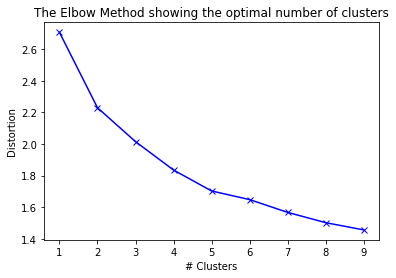

In [26]:
plt.plot(num_clusters_to_iterate, distortions, 'bx-')
plt.xlabel('# Clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal number of clusters')
plt.show()

# =============================================================

# 4. Cluster the data

# =============================================================

### Use the above graph to set the number of clusters

In [27]:
num_clusters = 8

## Find out which of the clusters each df row is in

#### Cluster the data

In [28]:
clustering = SpectralClustering(n_clusters=num_clusters, assign_labels="discretize", random_state=0).fit(standard_train_array)
clusters_label = pd.DataFrame(clustering.labels_).rename(columns={0: "Cluster"})

#### Calculate the centroids of the clusters

In [29]:
kmeans = KMeans(n_clusters=num_clusters).fit(standard_train_array)
centroids = kmeans.cluster_centers_

#### Add a new column to the original data with the cluster each row is in

In [30]:
full_df_nd_cluster = pd.concat([original_df, clusters_label], axis=1)

In [31]:
full_df_nd_cluster.head()

,group,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight,Cluster
0,young,0.038441,0.630402,1.207295,1.050323,-0.535035,-1.913099,0.669323,0.660446,1
1,young,0.045673,0.630331,1.628191,0.205205,-0.133367,-1.423580,0.427207,0.719352,1
2,young,0.045468,0.602974,1.395572,0.383055,-0.344822,-1.719826,0.493249,0.688723,1
3,young,0.035789,0.635677,1.067831,0.823790,-0.229192,-1.484455,0.625835,0.675971,2
4,young,0.060655,0.636276,1.802964,0.329246,-0.616020,-2.561017,0.439912,0.655563,1


# =============================================================

# 5. Principal Component Analysis

# =============================================================

There are eight parameters in this model so princiapl component analysis is performed below on the data before performing Spectral clustering.

#### Inspect dataframe which PCA is being performed on

In [32]:
original_df.head()

,group,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
0,young,0.038441,0.630402,1.207295,1.050323,-0.535035,-1.913099,0.669323,0.660446
1,young,0.045673,0.630331,1.628191,0.205205,-0.133367,-1.423580,0.427207,0.719352
2,young,0.045468,0.602974,1.395572,0.383055,-0.344822,-1.719826,0.493249,0.688723
3,young,0.035789,0.635677,1.067831,0.823790,-0.229192,-1.484455,0.625835,0.675971
4,young,0.060655,0.636276,1.802964,0.329246,-0.616020,-2.561017,0.439912,0.655563


#### Use PCA to project the data to 2 dimensions

In [33]:
pca = PCA(n_components=2)

principal_components_array = pca.fit_transform(standard_train_array)

#### Look at how much variance these 2 axes explain

In [34]:
pca.explained_variance_ratio_

array([0.35076363, 0.25256747])

#### Add these principal component columns to the rest of the data

In [35]:
principal_df = pd.DataFrame(data = principal_components_array, columns = ['Principal_Component_1', 'Principal_Component_2'])
principal_df.head()

,Principal_Component_1,Principal_Component_2
0,-1.970190,0.722886
1,-1.043165,1.396775
2,-1.140724,1.209005
3,-1.853978,0.136993
4,-0.828755,2.600131


In [36]:
final_df = pd.concat([full_df_nd_cluster, principal_df], axis = 1)

In [37]:
final_df.head()

,group,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight,Cluster,Principal_Component_1,Principal_Component_2
0,young,0.038441,0.630402,1.207295,1.050323,-0.535035,-1.913099,0.669323,0.660446,1,-1.970190,0.722886
1,young,0.045673,0.630331,1.628191,0.205205,-0.133367,-1.423580,0.427207,0.719352,1,-1.043165,1.396775
2,young,0.045468,0.602974,1.395572,0.383055,-0.344822,-1.719826,0.493249,0.688723,1,-1.140724,1.209005
3,young,0.035789,0.635677,1.067831,0.823790,-0.229192,-1.484455,0.625835,0.675971,2,-1.853978,0.136993
4,young,0.060655,0.636276,1.802964,0.329246,-0.616020,-2.561017,0.439912,0.655563,1,-0.828755,2.600131


# =============================================================

# 6. Plot the clusters with the PCA axes

# =============================================================

## Plot the clusters

#### Choose the columns to plot

In [38]:
pc1 = final_df['Principal_Component_1']
pc2 = final_df['Principal_Component_2']
group = final_df["group"]
cluster = final_df["Cluster"]

#### Visualise 2D projection

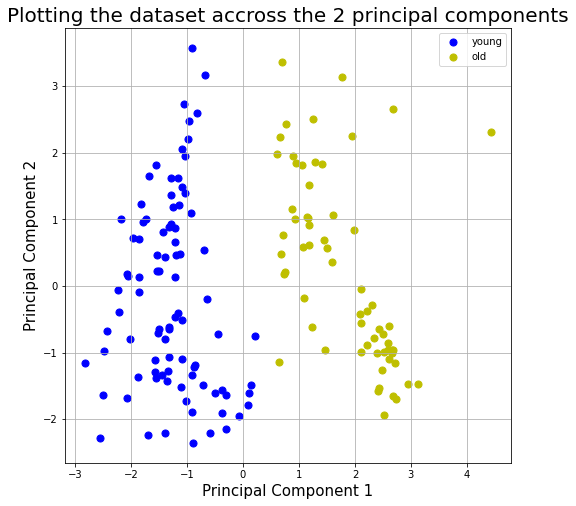

In [39]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Plotting the dataset accross the 2 principal components', fontsize = 20)

targets = ['young', 'old']
colors = ['b', 'y']

for target, color in zip(targets, colors):
    ax.scatter(pc1.loc[target == group], pc2.loc[target == group], c = color, s = 50)
    
ax.legend(targets)
ax.grid()

#### Plot the original data

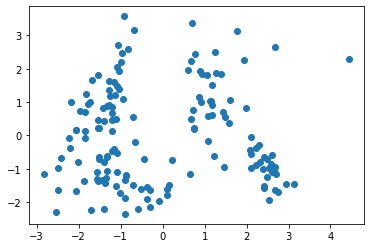

In [40]:
plt.scatter(pc1, pc2)

#### Plot the data colouring the different groups

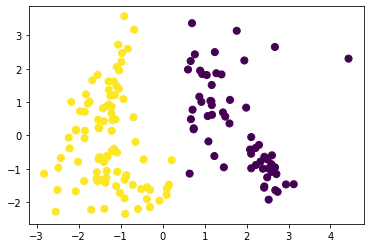

In [41]:
plt.scatter(pc1, pc2, c=np.where(0, 1, group=="young"), s=50)

#### Plot this data colouring the different clusters

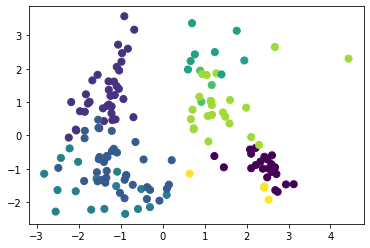

In [42]:
plt.scatter(pc1, pc2, c=cluster, s=50)

#### Plot this data with the clusters and their centroids

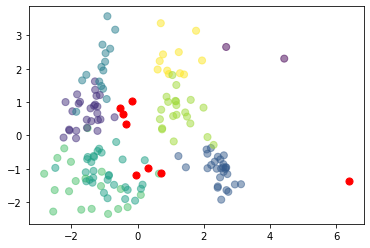

In [43]:
plt.scatter(pc1, pc2, c=kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

# =============================================================

# 7. Analyse the clusters

# =============================================================

## See how the 'Old' and 'Young' fall into these clusters

In [44]:
final_df.head()

,group,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight,Cluster,Principal_Component_1,Principal_Component_2
0,young,0.038441,0.630402,1.207295,1.050323,-0.535035,-1.913099,0.669323,0.660446,1,-1.970190,0.722886
1,young,0.045673,0.630331,1.628191,0.205205,-0.133367,-1.423580,0.427207,0.719352,1,-1.043165,1.396775
2,young,0.045468,0.602974,1.395572,0.383055,-0.344822,-1.719826,0.493249,0.688723,1,-1.140724,1.209005
3,young,0.035789,0.635677,1.067831,0.823790,-0.229192,-1.484455,0.625835,0.675971,2,-1.853978,0.136993
4,young,0.060655,0.636276,1.802964,0.329246,-0.616020,-2.561017,0.439912,0.655563,1,-0.828755,2.600131


#### Create a dataframe showing how many people people fell into each cluster

In [45]:
all_cluster_df = pd.DataFrame(final_df[["group", "Cluster"]].groupby("Cluster").count()).rename(columns={"group": "All"})

#### Change 'young' to 1 and 'old' to np.nan

In [46]:
final_df["group"] = final_df["group"].replace('old', np.nan).replace('young', 1)

#### Create a dataframe showing how many young people fell into each cluster

In [47]:
young_cluster_df = pd.DataFrame(final_df[["group", "Cluster"]].groupby("Cluster").count()).rename(columns={"group": "Young"})

#### Create a dataframe showing how many old people fell into each cluster

In [48]:
old_cluster_df = pd.DataFrame(final_df["group"].isnull().groupby(final_df["Cluster"]).sum().astype(int)).rename(columns={"group": "Old"})

#### Output how many 'young' and 'old' people fell into each cluster

In [49]:
pd.merge(all_cluster_df, pd.merge(young_cluster_df, old_cluster_df, how="inner", on="Cluster"), how="inner", on="Cluster")

,All,Young,Old
Cluster,,,
0,25,0,25
1,37,37,0
2,36,36,0
3,17,17,0
4,8,0,8
5,3,0,3
6,23,0,23
7,4,0,4
